### Install Detectron2 Dependencies

1. PyYAML
2. Pytorch
3. Pytorch Vision
4. OpenCV
5. Detectron2 (via direct link)

#### Notes:
1. Shell commands require "!" in the beginning for google colab. i.e. !pip



In [1]:

!pip install pyyaml==5.1

# The following are already preinstalled in Google Colab
# !pip install torch==1.8.1
# !pip install torchvision==1.8.1
# !pip install opencv-python

# Install Detectron2 from pip. Using `-f` flag to fetch a precompiled detectron2 from a link
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# OR
# !pip install 'git+https://github.com/facebookresearch/detectron2.git'

import torch, torchvision
import cv2
# Make sure CUDA GPU is attached in the Colab
!nvidia-smi

print(torch.__version__, torch.cuda.is_available())
print(cv2.__version__)

     |████████████████████████████████| 276kB 4.3MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44091 sha256=1fd8c53ec9d78b963e4ac4f3ec9df9331ac1340120b837cd0eada520c65e39bd
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
     |████████████████████████████████| 6.2MB 734kB/s 
     |████████████████████████████████| 51kB 2.7MB/s 
     |████████████████████████████████| 81kB 7.1MB/s 
     |████████████████████████████████| 112kB 31.8MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210317-cp37-none-any.whl size=58543 sha256=e9992eb8195ce05120327efb56e70e0781c4141d3b4dd827825e7480b4dd877b
  Stored in directory: /root/.cache/pip/wheels/d2/ee/3a/5c531

Sun Jun 13 06:48:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
# For Tensorboard (Easy Graphs)
setup_logger()

import numpy as np
import os, json, cv2, random

import sys
INSIDE_COLAB = 'google.colab' in sys.modules

if INSIDE_COLAB:
    from google.colab.patches import cv2_imshow
    print("Inside Google Colab")
# cv2.imshow crashes in google colab hence using a google colab patch



# detectron2 imports
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode


"""
Call this function when outputting the image. Handles colab quirks for
outputting an image

"""
def handle_cv2imshow(img):
    if INSIDE_COLAB:
        cv2_imshow(img)
    else:
        cv2.imshow("AnnotatedImage", img)
        cv2.waitKey(0)



Inside Google Colab


In [3]:
# Get the Red Pepper Dataset
# Moved to Gist/Github because could not install directly from **LINK**
!wget https://gist.github.com/theshapguy/ab3a98c4cdae1728fb64747d78499aea/raw/36d04bc21411acf4a86ad405356c0fe90d7ae533/paprika.zip
!unzip -o paprika.zip > /dev/null

--2021-06-13 06:48:59--  https://gist.github.com/theshapguy/ab3a98c4cdae1728fb64747d78499aea/raw/36d04bc21411acf4a86ad405356c0fe90d7ae533/paprika.zip
Resolving gist.github.com (gist.github.com)... 13.114.40.48
Connecting to gist.github.com (gist.github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://gist.githubusercontent.com/theshapguy/ab3a98c4cdae1728fb64747d78499aea/raw/36d04bc21411acf4a86ad405356c0fe90d7ae533/paprika.zip [following]
--2021-06-13 06:48:59--  https://gist.githubusercontent.com/theshapguy/ab3a98c4cdae1728fb64747d78499aea/raw/36d04bc21411acf4a86ad405356c0fe90d7ae533/paprika.zip
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23009563 (22M) [application/zip]
Saving to: ‘

#### Preparing the data for training

In [4]:
def get_paprika_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}

        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]

        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width


        annos = v["regions"]
        objs = []
        # for _, anno in annos.items():
        for anno in annos:
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                # Create a bounding box around the segmented pepper
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                # Extract Segmentation of where the pepper is
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

for d in ["train", "val"]:
    DatasetCatalog.register("paprika_" + d, lambda d=d: get_paprika_dicts("Paprika/" + d))
    MetadataCatalog.get("paprika_" + d).set(thing_classes=["paprika"])

paprika_metadata = MetadataCatalog.get("paprika_train")

#### Visualize some training dataset

In [5]:
def visuallize_image(d):
    # 'd' === one annotation in the via file
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=paprika_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    handle_cv2imshow(out.get_image()[:, :, ::-1])

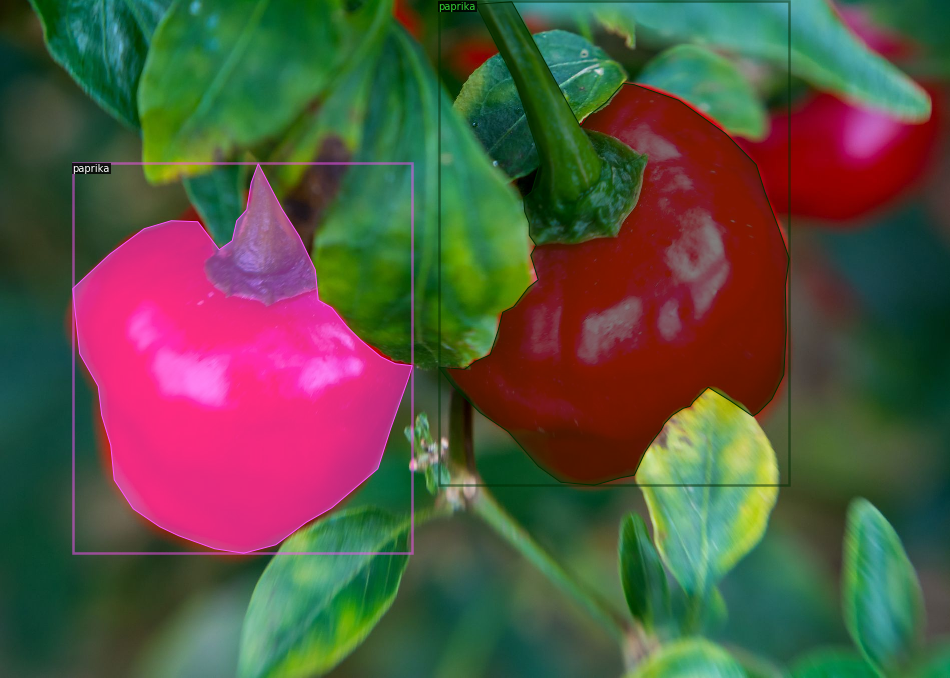

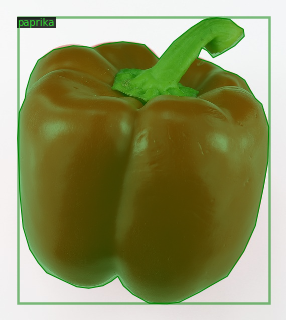

In [6]:
dataset_dicts = get_paprika_dicts("Paprika/train")

for d in random.sample(dataset_dicts, 2):
    # View Some Annomtated Image Images to check if they have been annotated
    # properly
    visuallize_image(d)

#### Setup configration for training at dataset

In [7]:
def train(dataset_name):
    cfg = get_cfg()
        
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")) # Get initial configuration from model zoo
    cfg.DATASETS.TRAIN = (dataset_name,)
    cfg.DATASETS.TEST = ()
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.BASE_LR = 0.01  # pick a good LR # learing rate was 0.01,0.02, 0.00025
    cfg.SOLVER.MAX_ITER =300    # 500,1000,300 was before, and 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
    # cfg.SOLVER.STEPS = []        # do not decay learning rate
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (paprika). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
    # NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    trainer = DefaultTrainer(cfg)
    trainer.resume_or_load(resume=False)
    trainer.train()

    return cfg

#### Train and update the configuration with the trained model

In [ ]:
cfg = train("paprika_train")

def update_configuration(cfg):
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
    return cfg

cfg = update_configuration(cfg)

[06/13 06:51:23 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:13, 12.8MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to i

[06/13 06:51:41 d2.engine.train_loop]: Starting training from iteration 0


#### Setup Predictor and Prediction Visualization

In [ ]:
def visuallize_prediction(predictor, d):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=paprika_metadata, 
                   scale=0.5,
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])


In [ ]:
predictor = DefaultPredictor(cfg)

dataset_dicts = get_paprika_dicts("Paprika/val")

for d in random.sample(dataset_dicts, 10):
    visuallize_prediction(predictor, d)

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output